## 0. Importing Necessary Libraries & Dependencies

In [37]:
# Importing Libraries
import torch
from torch import nn

print(f"PyTroch Version: {torch.__version__}")

# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

PyTroch Version: 2.5.1+cu124
Device: cuda


In [38]:
!nvidia-smi


Tue Jan 14 08:07:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  |   00000000:01:00.0 Off |                  N/A |
| 30%   35C    P2             53W /  360W |   11277MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

In [39]:
import requests
import zipfile
from pathlib import Path

# Set up path to datafolder
data_path = Path("data/")
image_data_path = data_path / "fruits_dataset"

# If the fruits_dataset folder doesn't exists, download it and prepare it.....
if image_data_path.is_dir():
  print(f"{image_data_path} directory already exists! Skipping download......")
else:
  print(f"{image_data_path} doesn't exists, creating one......")
  image_data_path.mkdir(parents=True, exist_ok=True)

# Download fruits_dataset
with open(data_path / "fruits_dataset.zip", "wb") as f:
  request = requests.get("https://github.com/nepal-manjil32/pytorch-models/raw/main/datasets/fruits_dataset.zip")
  print("Downloading fruits_classification dataset......")
  f.write(request.content)

# Unzip fruits_classification dataset
with zipfile.ZipFile(data_path / "fruits_dataset.zip", "r") as zip_ref:
  print("Unzipping fruits_dataset.zip......")
  zip_ref.extractall(image_data_path)

data\fruits_dataset directory already exists! Skipping download......
Unzipping fruits_dataset.zip......


## 2. Data Exploaration & Preparation

In [40]:
import os
def wal_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}")

wal_through_dir(image_data_path)

There are 2 directories and 0images in 'data\fruits_dataset
There are 2 directories and 1images in 'data\fruits_dataset\fruits_dataset
There are 10 directories and 0images in 'data\fruits_dataset\fruits_dataset\test
There are 0 directories and 89images in 'data\fruits_dataset\fruits_dataset\test\apple
There are 0 directories and 105images in 'data\fruits_dataset\fruits_dataset\test\avocado
There are 0 directories and 106images in 'data\fruits_dataset\fruits_dataset\test\banana
There are 0 directories and 105images in 'data\fruits_dataset\fruits_dataset\test\cherry
There are 0 directories and 105images in 'data\fruits_dataset\fruits_dataset\test\kiwi
There are 0 directories and 105images in 'data\fruits_dataset\fruits_dataset\test\mango
There are 0 directories and 97images in 'data\fruits_dataset\fruits_dataset\test\orange
There are 0 directories and 105images in 'data\fruits_dataset\fruits_dataset\test\pinenapple
There are 0 directories and 103images in 'data\fruits_dataset\fruits_data

In [41]:
# Setup training and testing paths
train_dir = image_data_path / "__MACOSX/train"
test_dir = image_data_path / "__MACOSX/test"

train_dir, test_dir

(WindowsPath('data/fruits_dataset/__MACOSX/train'),
 WindowsPath('data/fruits_dataset/__MACOSX/test'))

### 2.1 Visualization

In [42]:
image_data_path

WindowsPath('data/fruits_dataset')

Random Image Path: data\fruits_dataset\fruits_dataset\train\orange\img_821.jpeg
Image Class: orange
Image Height: 225
Image Width: 225


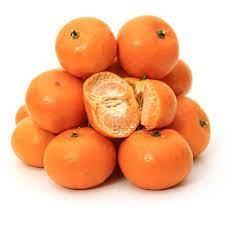

In [43]:
##-- Visualizing using PIL --##
import random
from pathlib import Path
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_data_path.glob("*/*/*/*.jpeg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open the image
img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

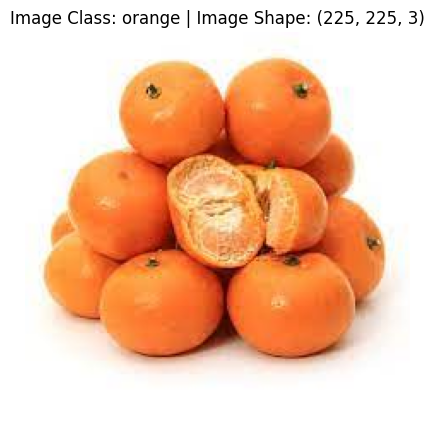

In [44]:
##-- Visulaizing using matplotlib --##
import numpy as np
import matplotlib.pyplot as plt

# Turn the images into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(6,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape}")
plt.axis(False)

## 3. Transforming Data

In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [46]:
##-- Image transformation script --##
train_image_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_image_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [47]:
transformed_image = train_image_transform(img)

In [48]:
##-- Function to visualize original and transformed image --##
def plot_transformed_image(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for img_pth in random_image_paths:
    with Image.open(img_pth) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {img_pth.parent.stem}", fontsize=16)

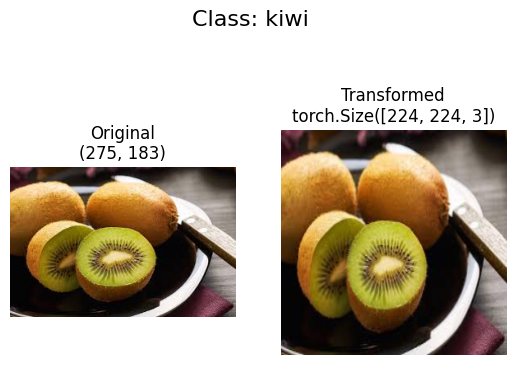

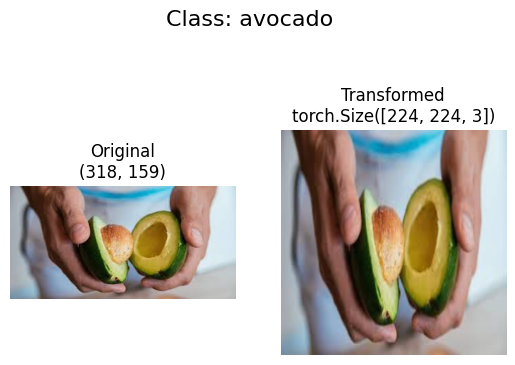

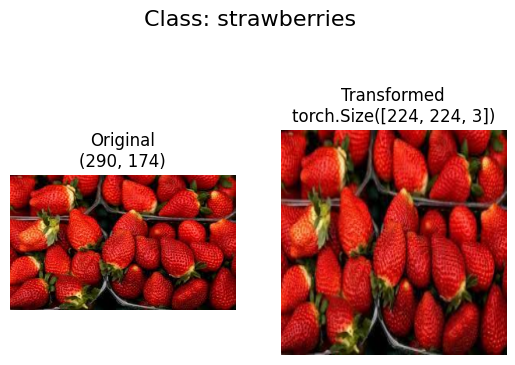

In [49]:
plot_transformed_image(image_paths=image_path_list, transform=train_image_transform, n=3)

## 4. Loading Image Data Using ImageFolder

We can load image classification data uing `torch.vision.datasets.ImageFolder`

**Note: **Since our dataset in the standard image classification format, we can use one of `torchvision.datasets` prebuilt functions

In [50]:
# _MACOSX is causing error and the actual path appears like this
train_dir = 'data/fruits_dataset/fruits_dataset/train'
test_dir = 'data/fruits_dataset/fruits_dataset/test'

In [51]:
train_dir, test_dir

('data/fruits_dataset/fruits_dataset/train',
 'data/fruits_dataset/fruits_dataset/test')

In [52]:
# Using ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_image_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_image_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2301
     Root location: data/fruits_dataset/fruits_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1025
     Root location: data/fruits_dataset/fruits_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [53]:
# Get class names
class_names = train_data.classes
class_names

['apple',
 'avocado',
 'banana',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

In [54]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'kiwi': 4,
 'mango': 5,
 'orange': 6,
 'pinenapple': 7,
 'strawberries': 8,
 'watermelon': 9}

In [55]:
# Index on the train data to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.0980, 0.0980, 0.0980,  ..., 0.0078, 0.0078, 0.0078],
         [0.0980, 0.0980, 0.0980,  ..., 0.0078, 0.0078, 0.0078],
         [0.0980, 0.0980, 0.0980,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.8941, 0.8941, 0.8902,  ..., 0.8902, 0.8863, 0.8863],
         [0.9059, 0.9059, 0.8902,  ..., 0.9059, 0.9098, 0.9098],
         [0.8941, 0.8941, 0.8863,  ..., 0.8706, 0.8627, 0.8549]],

        [[0.0784, 0.0784, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0784, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
         [0.0784, 0.0784, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9216, 0.9216],
         [0.9373, 0.9373, 0.9255,  ..., 0.9412, 0.9451, 0.9451],
         [0.9255, 0.9255, 0.9216,  ..., 0.9059, 0.8980, 0.8902]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0039, 0.0039, 0.0039],
         [0.0549, 0.0549, 0.0549,  ..., 0.0039, 0.0039, 0.0039],
         [0.0549, 0.0549, 0.0549,  ..., 0.0039, 0.0039, 0.

In [56]:
label

0

### 4.1 Turn Loaded Images Into `DataLoader`

A `DataLoader` is going to help us turn our Datasets into iterables and we can customise the batch_size so our model can see `batch_size` images at a time

In [57]:
# Turn train and test datsets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(72, 33)

In [58]:
# img, label = next(iter(train_dataloader))

# print(f"Image Shape: {img.shape} -> [BATCH_SIZE, color_channels, height, width]")
# print(f"Label Shape: {label.shape}")

## 5. VGG-16 Model

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16-1024x450.jpg" width=50% />

In [59]:
class VGG_16(nn.Module):

  def __init__(self, num_classes: int) -> None:
    super().__init__()

    # First Block
    self.CONV1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

     # Second Block
    self.CONV2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

     # Third Block
    self.CONV3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

     # Fourth Block
    self.CONV4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Fifth Block
    self.CONV5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.FC1 = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=7*7*512, out_features=4096),
    )

    self.FC2 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=4096, out_features=4096),
    )

    self.FC3 = nn.Sequential(
        nn.Linear(in_features=4096, out_features=num_classes)
    )

  def forward(self, x):
    x = self.CONV1(x)
    x = self.CONV2(x)
    x = self.CONV3(x)
    x = self.CONV4(x)
    x = self.CONV5(x)
    x = self.FC1(x)
    x = self.FC2(x)
    x = self.FC3(x)
    return x

In [61]:
torch.manual_seed(42)
model_0 = VGG_16(num_classes=len(class_names)).to(device)

model_0

VGG_16(
  (CONV1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (CONV2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (CONV3): Sequential(
    (0): Conv2d(128, 25

In [62]:
##-- Forward pass on single image --##
image_batch, label_batch = next(iter(train_dataloader)) # gets the first batch of images (32 images and its corresponding label)
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [63]:
len(image_batch), len(label_batch)

(32, 32)

In [64]:
label_batch[0]

tensor(5)

In [65]:
image_batch = image_batch.to(device)
label_batch = label_batch.to(device)

In [66]:
model_0(image_batch)

tensor([[ 0.4990,  0.1539,  0.5471,  0.4886, -0.9074,  0.4441, -0.3649,  0.7673,
          0.0225,  0.6510],
        [-0.1235, -0.2071, -1.0375,  0.6190, -0.1489,  0.1212,  0.6479,  0.1899,
          0.5043,  0.2653],
        [ 0.4717,  0.2137, -0.2364,  0.5442, -0.8277,  0.1660, -0.1150,  0.6327,
          0.1954,  0.0622],
        [ 0.0645,  0.3348,  0.0426,  0.2831, -0.5806,  0.4191,  0.3734,  0.3695,
         -0.0848, -0.9063],
        [ 0.5830,  0.2961,  0.2437, -0.0708,  0.0997,  0.0714,  0.5578,  0.2725,
          0.3206, -0.4054],
        [-0.3725, -0.4622, -0.4206,  0.0934,  0.2172,  0.8502,  0.8557,  0.6556,
          0.5694, -0.3722],
        [-0.1075, -0.6805, -0.0620,  0.1611, -0.5192, -0.5246,  0.3178,  0.3891,
          0.6183,  0.2666],
        [ 0.4007, -0.1268, -0.4995,  0.0870,  0.7010,  0.0330, -0.0268,  0.2425,
          0.3260,  0.0155],
        [-0.5746, -0.2901, -0.6249,  0.0677, -0.5954, -0.5025,  1.2573,  0.3755,
         -0.5133, -0.1590],
        [ 0.3184, -

In [67]:
##-- Detailed info about our model --##
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 227, 227])

Layer (type:depth-idx)                   Output Shape              Param #
VGG_16                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 113, 113]         --
│    └─Conv2d: 2-1                       [1, 64, 227, 227]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 227, 227]         128
│    └─ReLU: 2-3                         [1, 64, 227, 227]         --
│    └─Conv2d: 2-4                       [1, 64, 227, 227]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 227, 227]         128
│    └─ReLU: 2-6                         [1, 64, 227, 227]         --
│    └─MaxPool2d: 2-7                    [1, 64, 113, 113]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-8                       [1, 128, 113, 113]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 113, 113]        256
│    └─ReLU: 2-10                        [1, 128, 113, 113]        --
│

## 6. Training & Testing Loop

In [68]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()

  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Perform forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propogation
    loss.backward()

    # 5. Optimizer step step....
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)


  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [69]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

  # Put the model in evaluation model
  model.eval()

  # Set up test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy metrics across all batches
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()) / len(test_pred_labels)


  # Adjust metrics to get the average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [70]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
            }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn)

    # Print what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 6.1 Finding Optimal Learning Rate

In [71]:
# try:
#   from torch_lr_finder import LRFinder
# except:
#   !pip install torch-lr-finder
#   !pip install torch-lr-finder -v --global-option="apex"
#   from torch_lr_finder import LRFinder

# ##-- Tweaked version from fastai --# ref: https://github.com/nepal-manjil32/pytorch-lr-finder
# model = model_0
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

### 6.2 Train Model

In [72]:
NUM_EPOCHS = 60

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end = timer()
print(f"\n Total training time: {(end-start):.3f} seconds")

  2%|▏         | 1/60 [05:36<5:30:50, 336.44s/it]

Epoch: 1 | train_loss: 120.1852 |train_acc: 0.1404 |test_loss: 14.9048 |test_acc: 0.1525


  3%|▎         | 2/60 [11:13<5:25:37, 336.86s/it]

Epoch: 2 | train_loss: 29.1108 |train_acc: 0.1599 |test_loss: 2.6108 |test_acc: 0.2178


  5%|▌         | 3/60 [16:48<5:19:16, 336.08s/it]

Epoch: 3 | train_loss: 16.4960 |train_acc: 0.1552 |test_loss: 4.2432 |test_acc: 0.1657


  7%|▋         | 4/60 [22:22<5:12:48, 335.15s/it]

Epoch: 4 | train_loss: 11.9718 |train_acc: 0.1620 |test_loss: 3.5978 |test_acc: 0.1553


  8%|▊         | 5/60 [27:56<5:06:47, 334.68s/it]

Epoch: 5 | train_loss: 3.8525 |train_acc: 0.1981 |test_loss: 2.0742 |test_acc: 0.2254


 10%|█         | 6/60 [33:29<5:00:47, 334.21s/it]

Epoch: 6 | train_loss: 5.2940 |train_acc: 0.1942 |test_loss: 2.1209 |test_acc: 0.1648


 12%|█▏        | 7/60 [39:03<4:54:59, 333.96s/it]

Epoch: 7 | train_loss: 3.4922 |train_acc: 0.1973 |test_loss: 2.0323 |test_acc: 0.2083


 13%|█▎        | 8/60 [44:36<4:49:22, 333.89s/it]

Epoch: 8 | train_loss: 4.1107 |train_acc: 0.2095 |test_loss: 2.2156 |test_acc: 0.2348


 15%|█▌        | 9/60 [50:10<4:43:47, 333.87s/it]

Epoch: 9 | train_loss: 2.4789 |train_acc: 0.2386 |test_loss: 1.8628 |test_acc: 0.2320


 17%|█▋        | 10/60 [55:44<4:38:09, 333.78s/it]

Epoch: 10 | train_loss: 2.4067 |train_acc: 0.2099 |test_loss: 1.8678 |test_acc: 0.2623


 18%|█▊        | 11/60 [1:01:18<4:32:35, 333.79s/it]

Epoch: 11 | train_loss: 2.0158 |train_acc: 0.2800 |test_loss: 1.7434 |test_acc: 0.3078


 20%|██        | 12/60 [1:06:51<4:27:01, 333.78s/it]

Epoch: 12 | train_loss: 1.8806 |train_acc: 0.3341 |test_loss: 1.6331 |test_acc: 0.3447


 22%|██▏       | 13/60 [1:12:25<4:21:25, 333.73s/it]

Epoch: 13 | train_loss: 1.7992 |train_acc: 0.3455 |test_loss: 1.6743 |test_acc: 0.3759


 23%|██▎       | 14/60 [1:17:58<4:15:49, 333.69s/it]

Epoch: 14 | train_loss: 1.7258 |train_acc: 0.3741 |test_loss: 1.6117 |test_acc: 0.3911


 25%|██▌       | 15/60 [1:23:32<4:10:20, 333.78s/it]

Epoch: 15 | train_loss: 1.6424 |train_acc: 0.3935 |test_loss: 1.5712 |test_acc: 0.3826


 27%|██▋       | 16/60 [1:29:07<4:04:49, 333.86s/it]

Epoch: 16 | train_loss: 1.6590 |train_acc: 0.3899 |test_loss: 1.5625 |test_acc: 0.4062


 28%|██▊       | 17/60 [1:34:40<3:59:12, 333.78s/it]

Epoch: 17 | train_loss: 1.6803 |train_acc: 0.3967 |test_loss: 1.6622 |test_acc: 0.3731


 30%|███       | 18/60 [1:40:15<3:53:48, 334.01s/it]

Epoch: 18 | train_loss: 1.5967 |train_acc: 0.4048 |test_loss: 1.5788 |test_acc: 0.3674


 32%|███▏      | 19/60 [1:45:48<3:48:04, 333.77s/it]

Epoch: 19 | train_loss: 1.5827 |train_acc: 0.4337 |test_loss: 1.5579 |test_acc: 0.4062


 33%|███▎      | 20/60 [1:51:22<3:42:34, 333.85s/it]

Epoch: 20 | train_loss: 1.6491 |train_acc: 0.4039 |test_loss: 1.5325 |test_acc: 0.4261


 35%|███▌      | 21/60 [1:56:57<3:37:10, 334.10s/it]

Epoch: 21 | train_loss: 1.6152 |train_acc: 0.4148 |test_loss: 1.4567 |test_acc: 0.4081


 37%|███▋      | 22/60 [2:02:30<3:31:24, 333.81s/it]

Epoch: 22 | train_loss: 1.6243 |train_acc: 0.4202 |test_loss: 1.5418 |test_acc: 0.4261


 38%|███▊      | 23/60 [2:08:04<3:25:52, 333.86s/it]

Epoch: 23 | train_loss: 1.4904 |train_acc: 0.4702 |test_loss: 1.5017 |test_acc: 0.4650


 40%|████      | 24/60 [2:13:37<3:20:11, 333.66s/it]

Epoch: 24 | train_loss: 1.4989 |train_acc: 0.4480 |test_loss: 1.4233 |test_acc: 0.4498


 42%|████▏     | 25/60 [2:19:09<3:14:17, 333.08s/it]

Epoch: 25 | train_loss: 1.4604 |train_acc: 0.4619 |test_loss: 1.4850 |test_acc: 0.4375


 43%|████▎     | 26/60 [2:24:42<3:08:47, 333.16s/it]

Epoch: 26 | train_loss: 1.4470 |train_acc: 0.4742 |test_loss: 1.4370 |test_acc: 0.4640


 45%|████▌     | 27/60 [2:30:15<3:03:13, 333.13s/it]

Epoch: 27 | train_loss: 1.4661 |train_acc: 0.4639 |test_loss: 1.4508 |test_acc: 0.4451


 47%|████▋     | 28/60 [2:35:48<2:57:42, 333.22s/it]

Epoch: 28 | train_loss: 1.3900 |train_acc: 0.4830 |test_loss: 1.4306 |test_acc: 0.4773


 48%|████▊     | 29/60 [2:41:21<2:52:07, 333.14s/it]

Epoch: 29 | train_loss: 1.4381 |train_acc: 0.4860 |test_loss: 1.4569 |test_acc: 0.4602


 50%|█████     | 30/60 [2:46:55<2:46:36, 333.23s/it]

Epoch: 30 | train_loss: 1.3640 |train_acc: 0.5051 |test_loss: 1.4367 |test_acc: 0.4517


 52%|█████▏    | 31/60 [2:52:28<2:41:07, 333.36s/it]

Epoch: 31 | train_loss: 1.4233 |train_acc: 0.4974 |test_loss: 1.3643 |test_acc: 0.5038


 53%|█████▎    | 32/60 [2:58:02<2:35:31, 333.26s/it]

Epoch: 32 | train_loss: 1.3797 |train_acc: 0.5081 |test_loss: 1.4492 |test_acc: 0.4337


 55%|█████▌    | 33/60 [3:03:34<2:29:54, 333.12s/it]

Epoch: 33 | train_loss: 1.4678 |train_acc: 0.4910 |test_loss: 1.3961 |test_acc: 0.4555


 57%|█████▋    | 34/60 [3:09:07<2:24:20, 333.09s/it]

Epoch: 34 | train_loss: 1.3778 |train_acc: 0.5024 |test_loss: 1.3982 |test_acc: 0.5009


 58%|█████▊    | 35/60 [3:14:40<2:18:46, 333.07s/it]

Epoch: 35 | train_loss: 1.4475 |train_acc: 0.4920 |test_loss: 1.3704 |test_acc: 0.5123


 60%|██████    | 36/60 [3:20:13<2:13:12, 333.03s/it]

Epoch: 36 | train_loss: 1.4399 |train_acc: 0.5007 |test_loss: 1.3833 |test_acc: 0.4886


 62%|██████▏   | 37/60 [3:25:46<2:07:40, 333.05s/it]

Epoch: 37 | train_loss: 1.3216 |train_acc: 0.5290 |test_loss: 1.2762 |test_acc: 0.5322


 63%|██████▎   | 38/60 [3:31:19<2:02:04, 332.94s/it]

Epoch: 38 | train_loss: 1.3017 |train_acc: 0.5245 |test_loss: 1.3416 |test_acc: 0.5369


 65%|██████▌   | 39/60 [3:36:53<1:56:40, 333.34s/it]

Epoch: 39 | train_loss: 1.3797 |train_acc: 0.5154 |test_loss: 1.3584 |test_acc: 0.4943


 67%|██████▋   | 40/60 [3:42:28<1:51:13, 333.67s/it]

Epoch: 40 | train_loss: 1.2625 |train_acc: 0.5429 |test_loss: 1.4004 |test_acc: 0.5133


 68%|██████▊   | 41/60 [3:48:01<1:45:39, 333.65s/it]

Epoch: 41 | train_loss: 1.3029 |train_acc: 0.5452 |test_loss: 1.4179 |test_acc: 0.4801


 70%|███████   | 42/60 [3:53:35<1:40:04, 333.60s/it]

Epoch: 42 | train_loss: 1.3305 |train_acc: 0.5271 |test_loss: 1.3260 |test_acc: 0.5123


 72%|███████▏  | 43/60 [3:59:09<1:34:32, 333.68s/it]

Epoch: 43 | train_loss: 1.2940 |train_acc: 0.5645 |test_loss: 1.3996 |test_acc: 0.4953


 73%|███████▎  | 44/60 [4:04:42<1:28:57, 333.58s/it]

Epoch: 44 | train_loss: 1.3705 |train_acc: 0.5260 |test_loss: 1.2420 |test_acc: 0.5379


 75%|███████▌  | 45/60 [4:10:17<1:23:29, 333.94s/it]

Epoch: 45 | train_loss: 1.2900 |train_acc: 0.5572 |test_loss: 1.3134 |test_acc: 0.5455


 77%|███████▋  | 46/60 [4:15:50<1:17:50, 333.58s/it]

Epoch: 46 | train_loss: 1.2766 |train_acc: 0.5581 |test_loss: 1.3756 |test_acc: 0.5275


 78%|███████▊  | 47/60 [4:21:24<1:12:19, 333.77s/it]

Epoch: 47 | train_loss: 1.3006 |train_acc: 0.5509 |test_loss: 1.6368 |test_acc: 0.4470


 80%|████████  | 48/60 [4:26:58<1:06:45, 333.82s/it]

Epoch: 48 | train_loss: 1.2381 |train_acc: 0.5719 |test_loss: 1.2210 |test_acc: 0.5862


 82%|████████▏ | 49/60 [4:32:30<1:01:08, 333.49s/it]

Epoch: 49 | train_loss: 1.3020 |train_acc: 0.5735 |test_loss: 1.7106 |test_acc: 0.4811


 83%|████████▎ | 50/60 [4:38:05<55:37, 333.74s/it]  

Epoch: 50 | train_loss: 1.3058 |train_acc: 0.5595 |test_loss: 1.4823 |test_acc: 0.4896


 85%|████████▌ | 51/60 [4:43:37<50:00, 333.40s/it]

Epoch: 51 | train_loss: 1.2322 |train_acc: 0.5750 |test_loss: 1.3366 |test_acc: 0.5521


 87%|████████▋ | 52/60 [4:49:11<44:26, 333.34s/it]

Epoch: 52 | train_loss: 1.2150 |train_acc: 0.5728 |test_loss: 1.3047 |test_acc: 0.5559


 88%|████████▊ | 53/60 [4:54:45<38:55, 333.68s/it]

Epoch: 53 | train_loss: 1.1164 |train_acc: 0.6218 |test_loss: 1.3122 |test_acc: 0.5331


 90%|█████████ | 54/60 [5:00:20<33:23, 333.99s/it]

Epoch: 54 | train_loss: 1.1780 |train_acc: 0.5952 |test_loss: 1.2401 |test_acc: 0.5587


 92%|█████████▏| 55/60 [5:05:54<27:50, 334.05s/it]

Epoch: 55 | train_loss: 1.2038 |train_acc: 0.5953 |test_loss: 1.1983 |test_acc: 0.5786


 93%|█████████▎| 56/60 [5:11:27<22:15, 333.79s/it]

Epoch: 56 | train_loss: 1.0992 |train_acc: 0.6233 |test_loss: 1.1427 |test_acc: 0.5985


 95%|█████████▌| 57/60 [5:17:02<16:42, 334.05s/it]

Epoch: 57 | train_loss: 1.1159 |train_acc: 0.6224 |test_loss: 1.2027 |test_acc: 0.5814


 97%|█████████▋| 58/60 [5:22:35<11:07, 333.84s/it]

Epoch: 58 | train_loss: 1.1105 |train_acc: 0.6376 |test_loss: 1.2812 |test_acc: 0.5795


 98%|█████████▊| 59/60 [5:28:09<05:33, 333.73s/it]

Epoch: 59 | train_loss: 1.1883 |train_acc: 0.5920 |test_loss: 1.2264 |test_acc: 0.5511


100%|██████████| 60/60 [5:34:29<00:00, 334.50s/it]

Epoch: 60 | train_loss: 1.0856 |train_acc: 0.6354 |test_loss: 1.1407 |test_acc: 0.6184

 Total training time: 20069.766 seconds


In [75]:
def plot_loss_curves(results: dict[str, list[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

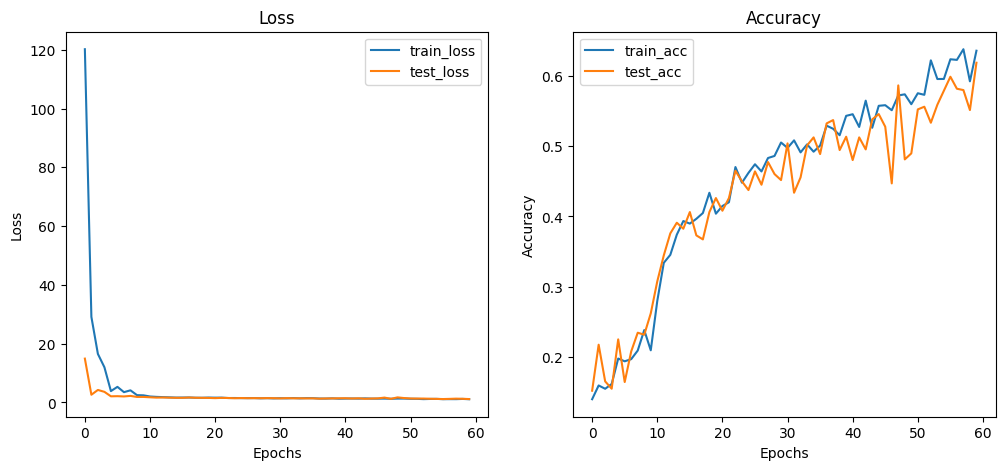

In [76]:
plot_loss_curves(model_0_results)